# Import the libraries and the data

In [14]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import metrics
import tensorflow as tf
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

print(df.shape)
df.head()

(48204, 9)


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


# Definition of required functions

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    #print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [18]:
def multiple_data_prep_function(predictors, target, start, end, window, horizon):
    '''
    Prepare univariate data that is suitable for a time series
    
    Args:
        predictors (float64): Scaled values for the predictors, numpy array of floats 
        target (float64): Scaled values for the target variable, numpy array of floats       
        start (int): Start point of range, integer
        end (int): End point of range, integer
        window (int): Number of units to be viewed per step, integer
        horizon (int): Number of units to be predicted, integer
    
    Returns:
        X (float64): Generated X-values for each step, numpy array of floats
        y (float64): Generated y-values for each step, numpy array of floats
    '''   
    X = []
    y = []

    start = start + window
    if end is None:
        end = len(predictors) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(predictors[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

# Data pre-processing

## Drop Duplicates

In [19]:
df = df.drop_duplicates(subset=['date_time'], keep=False)

df.shape

(35130, 9)

## Feature Encoding

In [20]:
# Encode feature 'holiday'
dummy_holiday = pd.get_dummies(df['holiday'], prefix="holiday")
column_name = df.columns.values.tolist()
column_name.remove('holiday')
df = df[column_name].join(dummy_holiday)

# Encode feature 'weather_main'
dummy_weather_main = pd.get_dummies(df['weather_main'], prefix="weather_main")
column_name = df.columns.values.tolist()
column_name.remove('weather_main')
df = df[column_name].join(dummy_weather_main)


# Encode feature 'weather_description'
dummy_weather_description = pd.get_dummies(df['weather_description'], prefix="weather_description")
column_name = df.columns.values.tolist()
column_name.remove('weather_description')
df = df[column_name].join(dummy_weather_description)

# Print final dataframe
print()
print('Shape of new dataframe: ' + str(df.shape))


Shape of new dataframe: (35130, 60)


## Check for Feature Importance

In [21]:
column_names_predictors = df.columns.values.tolist()

# Exclude target variable and date_time
column_names_predictors.remove('traffic_volume')
column_names_predictors.remove('date_time')

column_name_criterium = 'traffic_volume'

print('Length of remaining predictors: ' + str(len(column_names_predictors)))
print()
print('Target Variable: ' + str(column_name_criterium))

Length of remaining predictors: 58

Target Variable: traffic_volume


In [22]:
model = XGBRegressor()
model.fit(df[column_names_predictors],df[column_name_criterium])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

importance_type

+ `weight` - the number of times a feature is used to split the data across all trees.
+ `gain` - the average gain across all splits the feature is used in.
+ `cover` - the average coverage across all splits the feature is used in.
+ `total_gain` - the total gain across all splits the feature is used in.
+ `total_cover` - the total coverage across all splits the feature is used in.



Length of remaining predictors after XGB: 44


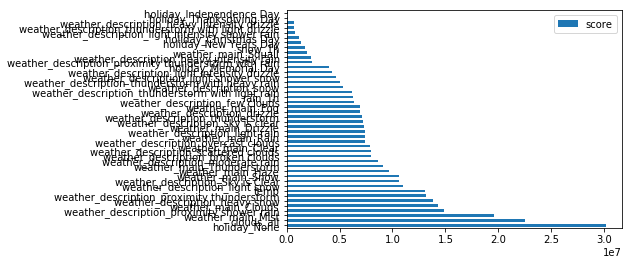

In [23]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh')

print()
print('Length of remaining predictors after XGB: ' + str(len(data)))

In [24]:
# Get column names of remaining predictors after XGB
features_to_keep = list(data.index)
# Append name of target variable
features_to_keep.append(column_name_criterium)

# Create final dataframe
final_df = df[features_to_keep]

print()
print('Length of features_to_keep: ' + str(len(features_to_keep)))
print('(includes 44 predictors and the target variable)')
print()
print('Shape of final dataframe: ' + str(final_df.shape))


Length of features_to_keep: 45
(includes 44 predictors and the target variable)

Shape of final dataframe: (35130, 45)


## Generate Test Set

In [25]:
test_data = final_df.tail(10)

final_df = final_df.drop(final_df.tail(10).index)

final_df.shape

(35120, 45)

## Feature Scaling

In [26]:
scaler_x = preprocessing.MinMaxScaler()
scaler_y = preprocessing.MinMaxScaler()


x_scaled = scaler_x.fit_transform(final_df)
y_scaled = scaler_y.fit_transform(final_df[[column_name_criterium]])

## Train-Validation Split

In [27]:
multi_hist_window_hs = 48
horizon_hs = 10
train_split_hs = 30000

x_train_multi_hs, y_train_multi_hs = multiple_data_prep_function(x_scaled, y_scaled, 
                                                                 0, train_split_hs, 
                                                                 multi_hist_window_hs, horizon_hs)

x_val_multi_hs, y_val_multi_hs= multiple_data_prep_function(x_scaled, y_scaled, 
                                                            train_split_hs, None, 
                                                            multi_hist_window_hs, horizon_hs)

In [28]:
print ('Length of first Single Window:')
print (len(x_train_multi_hs[0]))
print()
print ('Target horizon:')
print (y_train_multi_hs[0])

Length of first Single Window:
48

Target horizon:
[[0.75563187]
 [0.78475275]
 [0.86428571]
 [0.83200549]
 [0.67403846]
 [0.48118132]
 [0.41717033]
 [0.38763736]
 [0.27362637]
 [0.16016484]]


## Prepare training and test data using tf

In [29]:
BATCH_SIZE_hs = 256
BUFFER_SIZE_hs = 150

train_multi_hs = tf.data.Dataset.from_tensor_slices((x_train_multi_hs, y_train_multi_hs))
train_multi_hs = train_multi_hs.cache().shuffle(BUFFER_SIZE_hs).batch(BATCH_SIZE_hs).repeat()

validation_multi_hs = tf.data.Dataset.from_tensor_slices((x_val_multi_hs, y_val_multi_hs))
validation_multi_hs = validation_multi_hs.batch(BATCH_SIZE_hs).repeat()

# Neural Networks with mult. predictors

In [30]:
n_steps_per_epoch = 117
n_validation_steps = 20
n_epochs = 100

## LSTM

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, input_shape=x_train_multi_hs.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=100,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_hs)])

model.compile(loss='mse',
              optimizer='adam')

In [32]:
model_path = 'model/lstm_model_multi.h5'

In [33]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [34]:
history = model.fit(train_multi_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_multi_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 28s 192ms/step - loss: 0.1047 - val_loss: 0.0507
Epoch 2/100
117/117 [==============================] - 19s 159ms/step - loss: 0.0576 - val_loss: 0.0472
Epoch 3/100
117/117 [==============================] - 18s 158ms/step - loss: 0.0539 - val_loss: 0.0436
Epoch 4/100
117/117 [==============================] - 19s 164ms/step - loss: 0.0512 - val_loss: 0.0409
Epoch 5/100
117/117 [==============================] - 19s 165ms/step - loss: 0.0493 - val_loss: 0.0385
Epoch 6/100
117/117 [==============================] - 19s 164ms/step - loss: 0.0475 - val_loss: 0.0366
Epoch 7/100
117/117 [==============================] - 19s 165ms/step - loss: 0.0466 - val_loss: 0.0351
Epoch 8/100
117/117 [==============================] - 19s 163ms/step - loss: 0.0458 - val_loss: 0.0344
Epoch 9/100
117/117 [==============================] - 19s 159ms/step - loss: 0.0449 - val_loss: 0.0337
Epoch 10/100
117/117 [==============================] - 19s 158m

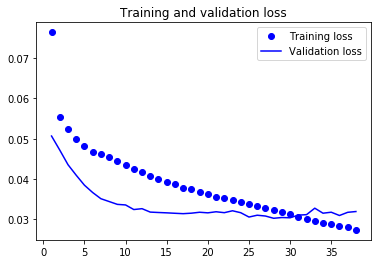

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
trained_lstm_model_multi = tf.keras.models.load_model(model_path)

In [37]:
df_temp = df[features_to_keep]
test_horizon = df_temp.tail(multi_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history)
test_scaled = test_scaled.reshape(1, test_scaled.shape[0], test_scaled.shape[1])

# Inserting the model
predicted_results = trained_lstm_model_multi.predict(test_scaled)
predicted_results

array([[0.14933552, 0.09497797, 0.12894598, 0.2421976 , 0.45351368,
        0.66217625, 0.78231215, 0.7868529 , 0.7606578 , 0.70402336]],
      dtype=float32)

In [38]:
predicted_inv_trans = scaler_y.inverse_transform(predicted_results)
predicted_inv_trans

array([[1087.1626 ,  691.43964,  938.7267 , 1763.1986 , 3301.5796 ,
        4820.643  , 5695.2324 , 5728.289  , 5537.589  , 5125.29   ]],
      dtype=float32)

In [39]:
timeseries_evaluation_metrics_func(test_data[column_name_criterium], predicted_inv_trans[0])

MSE is : 10021816.465203185
MAE is : 2957.593634033203
RMSE is : 3165.725266854846
MAPE is : 133.7328004076847
R2 is : -5.506314096931108



In [40]:
rmse_lstm_model_multi = np.sqrt(metrics.mean_squared_error(test_data[column_name_criterium], predicted_inv_trans[0]))

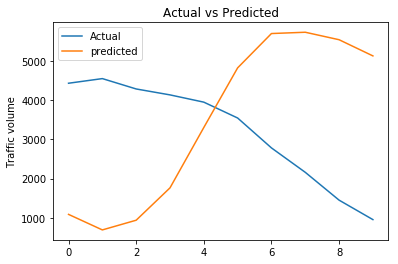

In [41]:
plt.plot(list(test_data[column_name_criterium]))
plt.plot(list(predicted_inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## Bidirectional LSTM

In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                                  input_shape=x_train_multi_hs.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_hs)])

model.compile(loss='mse',
              optimizer='adam')

In [43]:
model_path = 'model/bi_lstm_model_multi.h5'

In [44]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [45]:
history = model.fit(train_multi_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_multi_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 115s 931ms/step - loss: 0.1124 - val_loss: 0.0578
Epoch 2/100
117/117 [==============================] - 89s 759ms/step - loss: 0.0644 - val_loss: 0.0466
Epoch 3/100
117/117 [==============================] - 92s 790ms/step - loss: 0.0555 - val_loss: 0.0417
Epoch 4/100
117/117 [==============================] - 91s 777ms/step - loss: 0.0516 - val_loss: 0.0421
Epoch 5/100
117/117 [==============================] - 92s 787ms/step - loss: 0.0489 - val_loss: 0.0374
Epoch 6/100
117/117 [==============================] - 92s 785ms/step - loss: 0.0467 - val_loss: 0.0374
Epoch 7/100
117/117 [==============================] - 92s 785ms/step - loss: 0.0452 - val_loss: 0.0354
Epoch 8/100
117/117 [==============================] - 94s 801ms/step - loss: 0.0435 - val_loss: 0.0348
Epoch 9/100
117/117 [==============================] - 94s 803ms/step - loss: 0.0425 - val_loss: 0.0325
Epoch 10/100
117/117 [==============================] - 94s 801

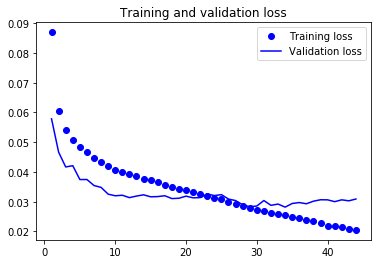

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
trained_bi_lstm_model_multi = tf.keras.models.load_model(model_path)

In [48]:
df_temp = df[features_to_keep]
test_horizon = df_temp.tail(multi_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history)
test_scaled = test_scaled.reshape(1, test_scaled.shape[0], test_scaled.shape[1])

# Inserting the model
predicted_results = trained_bi_lstm_model_multi.predict(test_scaled)
predicted_results

array([[0.1462175 , 0.09370288, 0.09414971, 0.16200566, 0.2994798 ,
        0.4475533 , 0.56405896, 0.6239846 , 0.6345759 , 0.6265972 ]],
      dtype=float32)

In [49]:
predicted_inv_trans = scaler_y.inverse_transform(predicted_results)
predicted_inv_trans

array([[1064.4634 ,  682.157  ,  685.40985, 1179.4012 , 2180.2131 ,
        3258.188  , 4106.349  , 4542.608  , 4619.7124 , 4561.628  ]],
      dtype=float32)

In [50]:
timeseries_evaluation_metrics_func(test_data[column_name_criterium], predicted_inv_trans[0])

MSE is : 8162045.917614721
MAE is : 2631.746478271484
RMSE is : 2856.92945618451
MAPE is : 112.40386017687347
R2 is : -4.298923064292916



In [51]:
rmse_bi_lstm_model_multi = np.sqrt(metrics.mean_squared_error(test_data[column_name_criterium], predicted_inv_trans[0]))

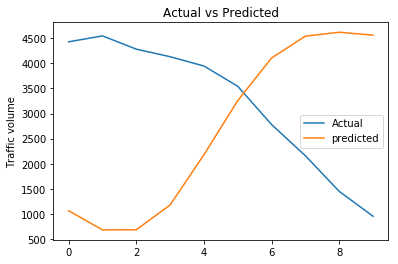

In [52]:
plt.plot(list(test_data[column_name_criterium]))
plt.plot(list(predicted_inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## GRU

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(100, input_shape=x_train_multi_hs.shape[-2:],return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=50,return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon_hs)])

model.compile(loss='mse',
              optimizer='adam')

In [54]:
model_path = 'model/gru_model_multi.h5'

In [55]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [56]:
history = model.fit(train_multi_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_multi_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 22s 161ms/step - loss: 0.1303 - val_loss: 0.0674
Epoch 2/100
117/117 [==============================] - 19s 167ms/step - loss: 0.0679 - val_loss: 0.0488
Epoch 3/100
117/117 [==============================] - 19s 161ms/step - loss: 0.0568 - val_loss: 0.0429
Epoch 4/100
117/117 [==============================] - 19s 159ms/step - loss: 0.0529 - val_loss: 0.0386
Epoch 5/100
117/117 [==============================] - 19s 159ms/step - loss: 0.0498 - val_loss: 0.0365
Epoch 6/100
117/117 [==============================] - 19s 159ms/step - loss: 0.0474 - val_loss: 0.0351
Epoch 7/100
117/117 [==============================] - 19s 159ms/step - loss: 0.0463 - val_loss: 0.0341
Epoch 8/100
117/117 [==============================] - 19s 160ms/step - loss: 0.0450 - val_loss: 0.0334
Epoch 9/100
117/117 [==============================] - 20s 168ms/step - loss: 0.0443 - val_loss: 0.0326
Epoch 10/100
117/117 [==============================] - 19s 159m

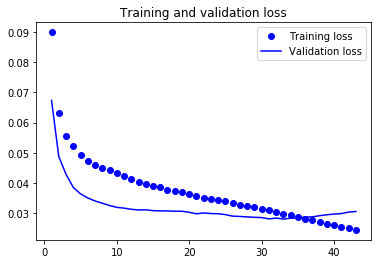

In [57]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
trained_gru_model_multi = tf.keras.models.load_model(model_path)

In [59]:
df_temp = df[features_to_keep]
test_horizon = df_temp.tail(multi_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history)
test_scaled = test_scaled.reshape(1, test_scaled.shape[0], test_scaled.shape[1])

# Inserting the model
predicted_results = trained_gru_model_multi.predict(test_scaled)
predicted_results

array([[0.149925  , 0.11994781, 0.18588951, 0.30544487, 0.46548158,
        0.5686811 , 0.60347944, 0.60006154, 0.6138898 , 0.64094937]],
      dtype=float32)

In [60]:
predicted_inv_trans = scaler_y.inverse_transform(predicted_results)
predicted_inv_trans

array([[1091.454  ,  873.22003, 1353.2756 , 2223.6387 , 3388.7058 ,
        4139.9985 , 4393.3306 , 4368.4478 , 4469.1177 , 4666.1113 ]],
      dtype=float32)

In [61]:
timeseries_evaluation_metrics_func(test_data[column_name_criterium], predicted_inv_trans[0])

MSE is : 6790521.144731341
MAE is : 2355.771173095703
RMSE is : 2605.8628407365077
MAPE is : 105.93741728158004
R2 is : -3.4085085376365



In [62]:
rmse_gru_model_multi = np.sqrt(metrics.mean_squared_error(test_data[column_name_criterium], predicted_inv_trans[0]))

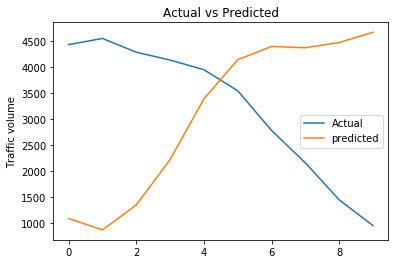

In [63]:
plt.plot(list(test_data[column_name_criterium]))
plt.plot(list(predicted_inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## Encoder Decoder LSTM

In [64]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(40, input_shape=x_train_multi_hs.shape[-2:], return_sequences=True),
    tf.keras.layers.LSTM(units=20,return_sequences=True),
    tf.keras.layers.LSTM(units=15),
    tf.keras.layers.RepeatVector(y_train_multi_hs.shape[1]), 
    tf.keras.layers.LSTM(units=40,return_sequences=True),
    tf.keras.layers.LSTM(units=25,return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=1))])

model.compile(loss='mse',
              optimizer='adam')

In [65]:
model_path = 'model/ed_lstm_model_multi.h5'

In [66]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [67]:
history = model.fit(train_multi_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_multi_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 25s 154ms/step - loss: 0.1263 - val_loss: 0.0808
Epoch 2/100
117/117 [==============================] - 13s 111ms/step - loss: 0.0790 - val_loss: 0.0751
Epoch 3/100
117/117 [==============================] - 13s 114ms/step - loss: 0.0765 - val_loss: 0.0735
Epoch 4/100
117/117 [==============================] - 14s 121ms/step - loss: 0.0750 - val_loss: 0.0588
Epoch 5/100
117/117 [==============================] - 14s 120ms/step - loss: 0.0587 - val_loss: 0.0476
Epoch 6/100
117/117 [==============================] - 13s 114ms/step - loss: 0.0533 - val_loss: 0.0455
Epoch 7/100
117/117 [==============================] - 13s 114ms/step - loss: 0.0510 - val_loss: 0.0438
Epoch 8/100
117/117 [==============================] - 13s 111ms/step - loss: 0.0491 - val_loss: 0.0419
Epoch 9/100
117/117 [==============================] - 13s 112ms/step - loss: 0.0473 - val_loss: 0.0406
Epoch 10/100
117/117 [==============================] - 12s 104m

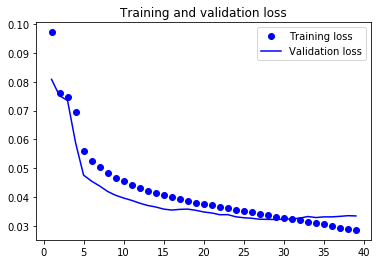

In [68]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [69]:
trained_ed_lstm_model_multi = tf.keras.models.load_model(model_path)

In [70]:
df_temp = df[features_to_keep]
test_horizon = df_temp.tail(multi_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history)
test_scaled = test_scaled.reshape(1, test_scaled.shape[0], test_scaled.shape[1])

# Inserting the model
predicted_results = trained_ed_lstm_model_multi.predict(test_scaled)
predicted_results

array([[[0.19395179],
        [0.16138805],
        [0.15746447],
        [0.2061087 ],
        [0.31133288],
        [0.4591507 ],
        [0.59601533],
        [0.6655741 ],
        [0.66637737],
        [0.62954354]]], dtype=float32)

In [71]:
predicted_inv_trans = scaler_y.inverse_transform(predicted_results.reshape(-1,1))
predicted_inv_trans

array([[1411.969 ],
       [1174.905 ],
       [1146.3414],
       [1500.4713],
       [2266.5034],
       [3342.6172],
       [4338.9917],
       [4845.3794],
       [4851.227 ],
       [4583.077 ]], dtype=float32)

In [72]:
timeseries_evaluation_metrics_func(test_data[column_name_criterium], predicted_inv_trans)

MSE is : 7448381.161058059
MAE is : 2531.2867919921873
RMSE is : 2729.172248330629
MAPE is : 67.50875144839114
R2 is : -3.8356011623014314



In [73]:
rmse_ed_lstm_model_multi = np.sqrt(metrics.mean_squared_error(test_data[column_name_criterium], predicted_inv_trans))

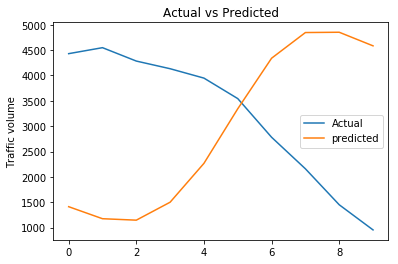

In [74]:
plt.plot(list(test_data[column_name_criterium]))
plt.plot(list(predicted_inv_trans))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

## CNN

In [75]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                                 input_shape=(x_train_multi_hs.shape[1], x_train_multi_hs.shape[2])))
model.add(tf.keras.layers.MaxPool1D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=horizon_hs))

model.compile(loss='mse',
              optimizer='adam')

In [76]:
model_path = 'model/cnn_model_multi.h5'

In [77]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    min_delta=0, patience=10, 
                                                    verbose=1, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', 
                                                      save_best_only=True, 
                                                      mode='min', verbose=0)]

In [78]:
history = model.fit(train_multi_hs, epochs=n_epochs, steps_per_epoch=n_steps_per_epoch,
                    validation_data=validation_multi_hs, validation_steps=n_validation_steps, verbose =1,
                    callbacks = keras_callbacks)

Epoch 1/100
117/117 [==============================] - 3s 22ms/step - loss: 0.1371 - val_loss: 0.0602
Epoch 2/100
117/117 [==============================] - 2s 21ms/step - loss: 0.0757 - val_loss: 0.0542
Epoch 3/100
117/117 [==============================] - 2s 19ms/step - loss: 0.0672 - val_loss: 0.0503
Epoch 4/100
117/117 [==============================] - 2s 20ms/step - loss: 0.0613 - val_loss: 0.0485
Epoch 5/100
117/117 [==============================] - 2s 19ms/step - loss: 0.0580 - val_loss: 0.0470
Epoch 6/100
117/117 [==============================] - 2s 19ms/step - loss: 0.0557 - val_loss: 0.0457
Epoch 7/100
117/117 [==============================] - 2s 19ms/step - loss: 0.0533 - val_loss: 0.0441
Epoch 8/100
117/117 [==============================] - 2s 19ms/step - loss: 0.0514 - val_loss: 0.0420
Epoch 9/100
117/117 [==============================] - 2s 19ms/step - loss: 0.0493 - val_loss: 0.0407
Epoch 10/100
117/117 [==============================] - 2s 19ms/step - loss: 0.047

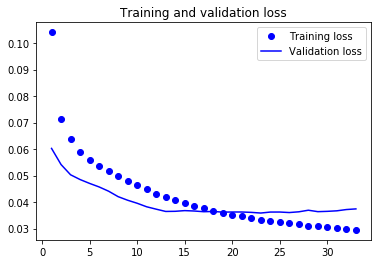

In [79]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [80]:
trained_cnn_model_multi = tf.keras.models.load_model(model_path)

In [81]:
df_temp = df[features_to_keep]
test_horizon = df_temp.tail(multi_hist_window_hs)
test_history = test_horizon.values


test_scaled = scaler_x.fit_transform(test_history)
test_scaled = test_scaled.reshape(1, test_scaled.shape[0], test_scaled.shape[1])

# Inserting the model
predicted_results = trained_cnn_model_multi.predict(test_scaled)
predicted_results

array([[0.5794493 , 0.6266309 , 0.6018325 , 0.53801847, 0.48688594,
        0.45493013, 0.41465926, 0.38147846, 0.36410382, 0.41638726]],
      dtype=float32)

In [82]:
predicted_inv_trans = scaler_y.inverse_transform(predicted_results)
predicted_inv_trans

array([[4218.391 , 4561.873 , 4381.341 , 3916.7744, 3544.5295, 3311.8914,
        3018.7195, 2777.163 , 2650.6758, 3031.2993]], dtype=float32)

In [83]:
timeseries_evaluation_metrics_func(test_data[column_name_criterium], predicted_inv_trans[0])

MSE is : 651139.4890260398
MAE is : 530.6485107421875
RMSE is : 806.932146481995
MAPE is : 36.70383676400023
R2 is : 0.5772704428156029



In [84]:
rmse_cnn_model_multi = np.sqrt(metrics.mean_squared_error(test_data[column_name_criterium], predicted_inv_trans[0]))

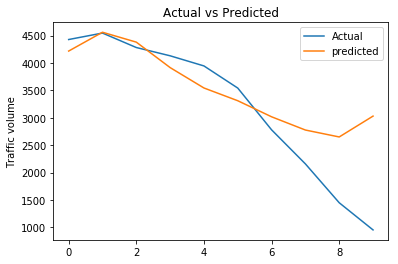

In [85]:
plt.plot(list(test_data[column_name_criterium]))
plt.plot(list(predicted_inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

# Get the Best Model

In [86]:
column_names = ["Model", "RMSE"]
df = pd.DataFrame(columns = column_names)

rmse_lstm_model_multi_df = pd.DataFrame([('lstm_model_multi', rmse_lstm_model_multi)], columns=column_names)
df = df.append(rmse_lstm_model_multi_df)

rmse_bi_lstm_model_multi_df = pd.DataFrame([('bi_lstm_model_multi', rmse_bi_lstm_model_multi)], columns=column_names)
df = df.append(rmse_bi_lstm_model_multi_df)

rmse_gru_model_multi_df = pd.DataFrame([('gru_model_multi', rmse_gru_model_multi)], columns=column_names)
df = df.append(rmse_gru_model_multi_df)

rmse_ed_lstm_model_multi_df = pd.DataFrame([('ed_lstm_model_multi', rmse_ed_lstm_model_multi)], columns=column_names)
df = df.append(rmse_ed_lstm_model_multi_df)

rmse_cnn_model_multi_df = pd.DataFrame([('cnn_model_multi', rmse_cnn_model_multi)], columns=column_names)
df = df.append(rmse_cnn_model_multi_df)

df

,Model,RMSE
0,lstm_model_multi,3165.725267
0,bi_lstm_model_multi,2856.929456
0,gru_model_multi,2605.862841
0,ed_lstm_model_multi,2729.172248
0,cnn_model_multi,806.932146


In [87]:
best_model = df.sort_values(by='RMSE', ascending=True)
best_model

,Model,RMSE
0,cnn_model_multi,806.932146
0,gru_model_multi,2605.862841
0,ed_lstm_model_multi,2729.172248
0,bi_lstm_model_multi,2856.929456
0,lstm_model_multi,3165.725267
